# Kaggle Digit Recogniser

## 	Introduction

This is my attempt the 'Digit Recogniser' challenge in Kaggle (link is here: https://www.kaggle.com/c/digit-recognizer/overview). Using my knowledge on CNNs and advice from other kernels submitted over time I have created this Python Notebook running through a neural network to recognise digits (0-9) from handwritten images.


## Load libraries

First step is to import the relevant libraries for use throughout the notebook.

In [57]:
import pandas as pd
import os
import numpy as np
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.layers.normalization import BatchNormalization
import matplotlib.pyplot as plt

## Data Preparation

The first step is to import and prepare the data. Thankfully this data is quite clean and so only need minimal transformation is required. One important part to note is the normalisation of the data to allow the CNN model to converge better, redsucing the effects of the pixel intensity.

In [58]:
train = pd.read_csv('./data/digit-recognizer/train.csv')
test = pd.read_csv('./data/digit-recognizer/test.csv')

In [59]:
# Get the labels as the Y values
Y_train = train["label"]

# Drop 'label' column and make this the X values
X_train = train.drop(labels = ["label"],axis = 1) 

In [60]:
# Here we should get the shape of the data and understand the dimensions
print("The data has " + str(X_train.shape[0]) + " rows")

The data has 42000 rows


In [61]:
# Normalize the data
X_train = X_train / 255.0
test = test / 255.0

In [62]:
# Reshape the data
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [63]:
# One hot encode the label data
Y_train = to_categorical(Y_train, num_classes = 10)

In [64]:
# Set the random seed
random_seed = 1234
# Split the train and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

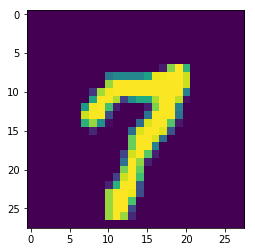

In [65]:
# Here we will plot one of the images as an example to show what it looks like
g = plt.imshow(X_train[100][:,:,0])
plt.show()

## CNN Model

Here we will set up our Neural Network model, using a 32 filters in the first 2 Conv2D layers and 64 filters in the last 2 Conv2D layers. Throughout this process we also involve Max Pooling, Batch Normalisation and Flattening and finally to ensure we get our 10 classes we add the 'Dense' and use a softmax.

What is also pivotal here is to augment the data before training it which was important to ensure we don't over fit the data.

In [66]:
# Set all the model paramters up now
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(BatchNormalization(axis=1))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization(axis=1))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization(axis=1))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization(axis=1))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization(axis=1))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(BatchNormalization(axis=1))
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [67]:
# Set the optimizer up
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [68]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
# Define the number of epochs (only used 2 here but can use a lot more)
epochs = 2 
batch_size = 86

In [ ]:
# Finally augment the data as well
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images
datagen.fit(X_train)

In [ ]:
# Fit the model
CNN_model = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/2


## Results and Test

Now we can run the model with the test data and upload it to Kaggle.

In [ ]:
# Predict results
results = model.predict(test)

# Select the value with the highest probability
results = np.argmax(results,axis = 1)

In [ ]:
# Now convert the results to a format we can upload to Kaggle
results = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

results.to_csv("./output/results.csv",index=False)